# GIM Mess Food-Waste Forecasting — Decision Tree Baseline

Run this notebook in **Google Colab** to train a simple, explainable model and export plots + model artifacts.

In [3]:
# --- Minimal setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib, json, io, requests

pd.set_option("display.max_columns", 200)

# Your GitHub repo (adjust branch if needed)
GITHUB_USER = "rohun-rajvanshi"
REPO        = "gim-food-waste-starter"
BRANCH      = "main"

RAW_BASE = f"https://raw.githubusercontent.com/{GITHUB_USER}/{REPO}/{BRANCH}"
CSV_PATH = "mess_waste_GIM_500.csv"     # it's at repo root, per your screenshot
CSV_URL  = f"{RAW_BASE}/{CSV_PATH}"
CSV_ALT  = None  # set to a local filename if you upload manually


In [4]:
def load_csv(csv_url, csv_alt=None):
    try:
        df = pd.read_csv(csv_url, parse_dates=['date'])
        print("Loaded from GitHub:", csv_url)
        return df
    except Exception as e:
        print("GitHub load failed:", e)

    if csv_alt is not None:
        try:
            df = pd.read_csv(csv_alt, parse_dates=['date'])
            print("Loaded local file:", csv_alt)
            return df
        except Exception as e:
            print("Local load failed:", e)

    # Last resort: manual upload
    from google.colab import files
    print("Upload your CSV (pick mess_waste_GIM_500.csv)")
    uploaded = files.upload()
    name = list(uploaded.keys())[0]
    return pd.read_csv(name, parse_dates=['date'])

df = load_csv(CSV_URL, CSV_ALT).sort_values('date').reset_index(drop=True)
df.head()


Loaded from GitHub: https://raw.githubusercontent.com/rohun-rajvanshi/gim-food-waste-starter/main/mess_waste_GIM_500.csv


,date,day_of_week,is_weekend,event_type,event_flag,temp_c,rain_mm,humidity,veg_main_dish,nonveg_main_dish,dessert,sweet_type,cooked_kg,consumed_kg,food_waste_kg
0,2024-07-01,Mon,0,Fest,1,28.4,35.1,87,"Jeera Rice, Dal Fry, Chapati",Scrambled Eggs/Banana,"Bread Pakoda, Ketchup",Fried,410.16,405.44,5.91
1,2024-07-02,Tue,0,NaN,0,30.7,0.0,77,Gravy- Gujarati Kadhi,Fish Kalia,"Bread Pakoda, Ketchup",Fried,408.56,396.67,12.84
2,2024-07-03,Wed,0,Fest,1,29.3,0.0,78,Chole Bhature,Bengali Fish Curry,Imarti,Fried,426.69,434.52,0.00
3,2024-07-04,Thu,0,NaN,0,29.5,25.9,82,Dry- Cabbage Masala,Fish Kalia,Fruit Custard,Milk-based,392.02,378.99,12.93
4,2024-07-05,Fri,0,NaN,0,28.1,0.0,79,"Moong Dal Chilla, Curd, Coriander Chutney",Egg Roast Curry,Mysore Pak,Fried,422.19,407.86,14.70


In [5]:
df2 = df.copy()

# Event flags
df2['is_exam']    = (df2['event_type'] == 'Exam').astype(int)
df2['is_holiday'] = (df2['event_type'] == 'Holiday').astype(int)
df2['is_fest']    = (df2['event_type'] == 'Fest').astype(int)

# Dessert flags (baseline = Other)
df2['sweet_milk']  = (df2['sweet_type'] == 'Milk-based').astype(int)
df2['sweet_fried'] = (df2['sweet_type'] == 'Fried').astype(int)
df2['sweet_halwa'] = (df2['sweet_type'] == 'Halwa-type').astype(int)

# Yesterday's waste (lag-1)
df2['yesterday_waste'] = df2['food_waste_kg'].shift(1)
df2 = df2.dropna(subset=['yesterday_waste']).reset_index(drop=True)

FEATURES = [
    'cooked_kg','temp_c','rain_mm','humidity',
    'is_weekend','is_exam','is_holiday','is_fest',
    'sweet_milk','sweet_fried','sweet_halwa',
    'yesterday_waste'
]

X = df2[FEATURES]
y = df2['food_waste_kg']
len(X), X.head(3)


(499,
    cooked_kg  temp_c  rain_mm  humidity  is_weekend  is_exam  is_holiday  \
 0     408.56    30.7      0.0        77           0        0           0   
 1     426.69    29.3      0.0        78           0        0           0   
 2     392.02    29.5     25.9        82           0        0           0   
 
    is_fest  sweet_milk  sweet_fried  sweet_halwa  yesterday_waste  
 0        0           0            1            0             5.91  
 1        1           0            1            0            12.84  
 2        0           1            0            0             0.00  )

In [6]:
n = len(df2)
i_tr = int(0.70*n)
i_va = int(0.85*n)

X_train, y_train = X.iloc[:i_tr], y.iloc[:i_tr]
X_val,   y_val   = X.iloc[i_tr:i_va], y.iloc[i_tr:i_va]
X_test,  y_test  = X.iloc[i_va:], y.iloc[i_va:]
dates_test = df2['date'].iloc[i_va:]

print(len(X_train), len(X_val), len(X_test))


349 75 75


In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def eval_block(y_true, y_hat, name):
    mae  = mean_absolute_error(y_true, y_hat)
    # Compat: some sklearn versions don't support `squared=False`
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    r2   = r2_score(y_true, y_hat)
    print(f"{name}: MAE={mae:.2f} kg | RMSE={rmse:.2f} kg | R²={r2:.3f}")
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}

# quick sweep for (max_depth, min_samples_leaf)
candidates = []
for md in [3,4,5,6,7]:
    for msl in [1,2,3,5]:
        m = DecisionTreeRegressor(max_depth=md, min_samples_leaf=msl, random_state=42)
        m.fit(X_train, y_train)
        mae = mean_absolute_error(y_val, m.predict(X_val))
        candidates.append((mae, md, msl))

best_mae, best_md, best_msl = sorted(candidates)[0]
print("Best (val) settings:", dict(max_depth=best_md, min_samples_leaf=best_msl, MAE=round(best_mae,2)))

best_tree = DecisionTreeRegressor(max_depth=best_md, min_samples_leaf=best_msl, random_state=42)
best_tree.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

test_pred = best_tree.predict(X_test)
metrics = eval_block(y_test, test_pred, f"Test (best tree md={best_md}, msl={best_msl})")
metrics


Best (val) settings: {'max_depth': 5, 'min_samples_leaf': 1, 'MAE': 6.66}
Test (best tree md=5, msl=1): MAE=6.40 kg | RMSE=8.10 kg | R²=0.786


{'MAE': 6.398675408669806, 'RMSE': 8.098453696701663, 'R2': 0.7863090664755418}

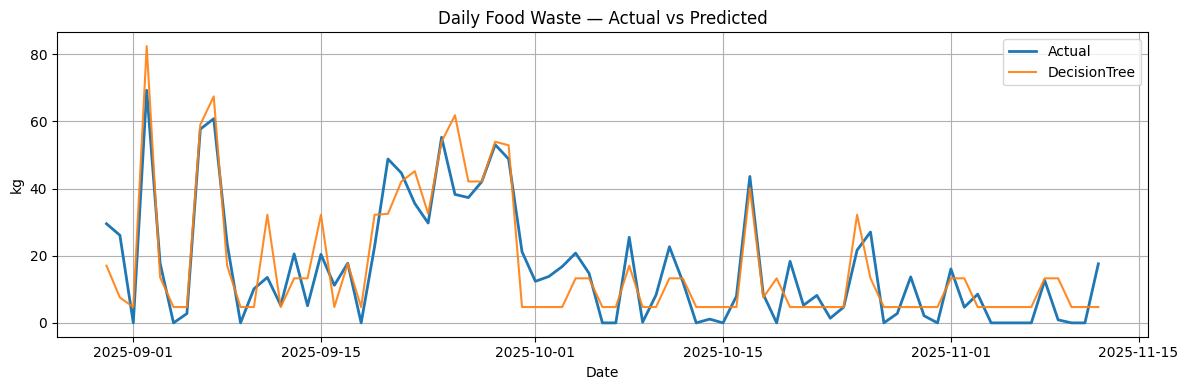

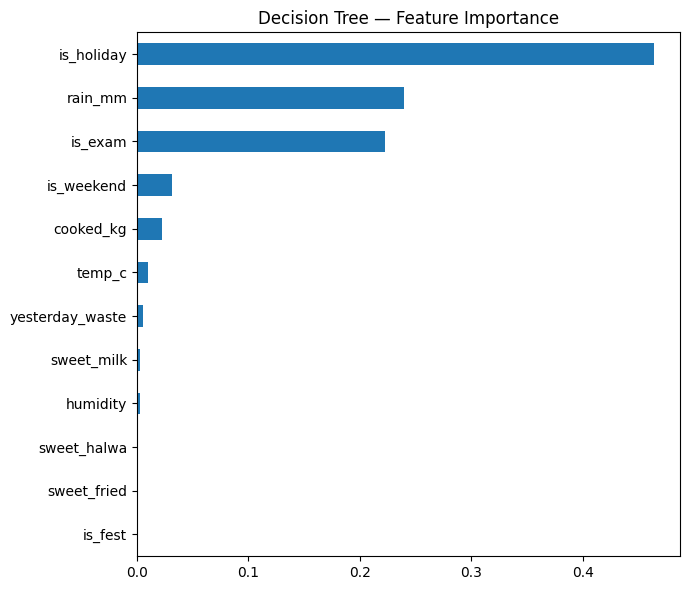

In [9]:
# Actual vs Predicted
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test.values, label="Actual", linewidth=2)
plt.plot(dates_test, test_pred, label="DecisionTree", alpha=0.9)
plt.title("Daily Food Waste — Actual vs Predicted")
plt.xlabel("Date"); plt.ylabel("kg")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("fig_avp.png", dpi=150)
plt.show()

# Feature importance
imp = pd.Series(best_tree.feature_importances_, index=FEATURES).sort_values(ascending=True)
plt.figure(figsize=(7,6))
imp.plot(kind='barh')
plt.title("Decision Tree — Feature Importance")
plt.tight_layout()
plt.savefig("fig_importance.png", dpi=150)
plt.show()


In [10]:
# Save
joblib.dump({"model": best_tree, "columns": FEATURES}, "gim_tree_model.joblib")
with open("metrics.json","w") as f: json.dump(metrics, f, indent=2)
with open("feature_columns.json","w") as f: json.dump(FEATURES, f, indent=2)

print("Saved: gim_tree_model.joblib, metrics.json, feature_columns.json, fig_avp.png, fig_importance.png")

# Download to your machine (optional)
from google.colab import files
for f in ["gim_tree_model.joblib", "metrics.json", "feature_columns.json", "fig_avp.png", "fig_importance.png"]:
    files.download(f)


Saved: gim_tree_model.joblib, metrics.json, feature_columns.json, fig_avp.png, fig_importance.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
def predict_tomorrow_tree(
    cooked_kg,
    event_type="None",          # 'None','Exam','Holiday','Fest','Club Event'
    sweet_type="Milk-based",    # 'Milk-based','Fried','Halwa-type','Other'
    temp_c=30.0, rain_mm=5.0, humidity=85,
    model_bundle_path="gim_tree_model.joblib", df_history=df2
):
    bundle = joblib.load(model_bundle_path)
    model, cols = bundle["model"], bundle["columns"]
    row = {
        'cooked_kg': cooked_kg,
        'temp_c': temp_c,
        'rain_mm': rain_mm,
        'humidity': humidity,
        'is_weekend': int((df_history['date'].iloc[-1] + pd.Timedelta(days=1)).dayofweek >= 5),
        'is_exam':    int(event_type == 'Exam'),
        'is_holiday': int(event_type == 'Holiday'),
        'is_fest':    int(event_type == 'Fest'),
        'sweet_milk':  int(sweet_type == 'Milk-based'),
        'sweet_fried': int(sweet_type == 'Fried'),
        'sweet_halwa': int(sweet_type == 'Halwa-type'),
        'yesterday_waste': float(df_history['food_waste_kg'].iloc[-1]),
    }
    X_row = pd.DataFrame([row])[cols]
    return float(model.predict(X_row)[0])

# Example:
predict_tomorrow_tree(
    cooked_kg=410,
    event_type="Exam",
    sweet_type="Fried",
    temp_c=29.5, rain_mm=8.0, humidity=86
)


42.11